In [30]:
%matplotlib inline
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2

FOLDER_DATASET = "data/"
IMAGE_DATASET = "UCF101_images/"
transformation = transforms.Compose([
transforms.RandomCrop(224),
transforms.ToTensor(),
])

class DataClass(Dataset):

    def __init__(self, data_folder, image_folder, file_name, transform=None):
        self.transform = transform
        self.data_folder = data_folder
        self.image_folder = image_folder
        self.width = 320
        self.height = 240
        
        with open(self.data_folder + file_name) as f:
            content = f.readlines()
        
        self.data = np.asarray([
            [i.split(" ")[0], i.split(" ")[1], i.split(" ")[2].split("\n")[0]] for i in content])

    # Generate image files for the given batch of videos
    # return batch_size * longest_sequence * channels * height * width
    def generatebatch(self, meta_batch):
        CHANNELS = 3
        
        folder = self.data_folder + self.image_folder
        batch_len = len(meta_batch)

        maximum_video_length = meta_batch[:,1].astype(int).max()
        
#         new_batch = np.zeros((batch_len, maximum_video_length, CHANNELS, self.height, self.width))
        new_batch = np.zeros((batch_len, maximum_video_length, CHANNELS, 200, 267))
        
        for batch_index, file in enumerate(meta_batch):
            filename = file[0]
            sequence_len = int(file[1])
            # generate transformation here if you want to
            
            for i in range(maximum_video_length - sequence_len, maximum_video_length): #pad the beginning
                index = i - maximum_video_length + sequence_len
                image = cv2.imread(folder + filename + "_" + str(index) + ".jpg")
                
                image = cv2.resize(image, (267,200), interpolation = cv2.INTER_AREA)
                #apply transformation here if you want to
                image = image.transpose(2,0,1)
                new_batch[batch_index][i] = image
            
        return new_batch
        
        
    # Get a batch of given batch size
    def getbatch(self, batchsize):
        batch = np.random.choice(len(self.data), batchsize, replace=False)
        batch = self.data[batch]
        labels = batch[:,2].astype(int)
        final_batch = self.generatebatch(batch)
        return final_batch, labels
    
    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.data)


In [31]:
train = DataClass(FOLDER_DATASET, IMAGE_DATASET, "train1.txt")
validation = DataClass(FOLDER_DATASET, IMAGE_DATASET, "val1.txt")

In [32]:
len(train), len(validation)

(8912, 625)

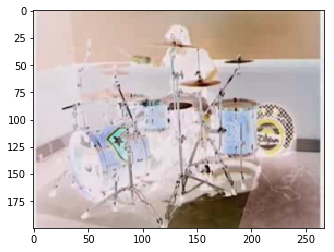

In [33]:
plt.imshow(train.getbatch(1)[0].squeeze()[0].transpose(1,2,0))